# HM2: Numerical Optimization for Logistic Regression.

### Name: Xing Fang


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.04744437 -0.04547818  0.00698364 -0.19965693 -0.09959291 -0.04257979
   0.0369194   0.04013505]]
test std = 
[[1.07116316 0.9400459  0.96178107 1.01608663 0.80365429 0.97141117
  0.98146444 1.01678836]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5874822563512243
Objective value at t=2 is 0.5457626689975008
Objective value at t=3 is 0.5236889573079135
Objective value at t=4 is 0.5100736799117122
Objective value at t=5 is 0.5009417557011928
Objective value at t=6 is 0.49449484687229867
Objective value at t=7 is 0.4897842226417198
Objective value at t=8 is 0.4862556300111487
Objective value at t=9 is 0.4835617255872231
Objective value at t=10 is 0.48147364150016597
Objective value at t=11 is 0.47983484639945084
Objective value at t=12 is 0.4785351472379199
Objective value at t=13 is 0.4774951516466567
Objective value at t=14 is 0.4766565490521402
Objective value at t=15 is 0.4759758088102148
Objective value at t=16 is 0.4754199733297629
Objective value at t=17 is 0.47496378103082104
Objective value at t=18 is 0.4745876578690141
Objective value at t=19 is 0.4742762899137312
Objective value at t=20 is 0.4740175927227579
Objective value at t=21 is 0.47380195661

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5416111264631289
Objective value at epoch t=1 is 0.513273455894327
Objective value at epoch t=2 is 0.5145119824015288
Objective value at epoch t=3 is 0.5111885994072326
Objective value at epoch t=4 is 0.5097976870638066
Objective value at epoch t=5 is 0.5041182654791376
Objective value at epoch t=6 is 0.5013091252336348
Objective value at epoch t=7 is 0.501577130306496
Objective value at epoch t=8 is 0.4996841459995555
Objective value at epoch t=9 is 0.4945521198540515
Objective value at epoch t=10 is 0.48838927005504473
Objective value at epoch t=11 is 0.4899662868205841
Objective value at epoch t=12 is 0.49159963356829844
Objective value at epoch t=13 is 0.4873567989067095
Objective value at epoch t=14 is 0.4875887186372217
Objective value at epoch t=15 is 0.48521253299540107
Objective value at epoch t=16 is 0.4844741607591449
Objective value at epoch t=17 is 0.4834810495743073
Objective value at epoch t=18 is 0.4815691785566497
Objective value at ep

# 4. Compare GD with SGD

Plot objective function values against epochs.

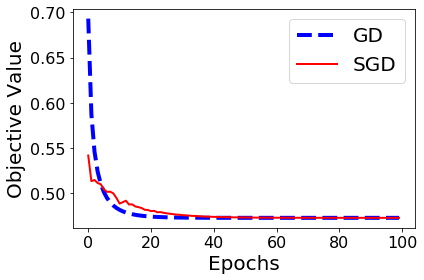

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2234375


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2265625


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    d = xi.shape[0]
    yx = numpy.multiply(yi, xi)
    yxw = numpy.dot(yx,w)
    
    loss = (1/b) * numpy.sum(numpy.log(1 + numpy.exp(-yxw)))
    reg = lam/2 * numpy.sum(w*w)
    obj = loss + reg
    
    g_loss = (1/b) * numpy.sum(numpy.divide((-yx), (1 + numpy.exp(yxw))).T, axis = 1)
    g = g_loss + lam * w
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [18]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n,d = x.shape
    objvals = numpy.zeros(max_epoch)
    if w is None:
        w = numpy.zeros((d,1))
    
    for t in range(max_epoch):
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0
        for i in range(0, n, b):
            xi = x_rand[i:i+b, :]
            yi = y_rand[i:i+b, :]
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            objval += obj
            w -= stepsize*g
        
        stepsize *= 0.9
        objval /= n/b #??????
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [40]:
# build function to find best stepsize based on cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def find_best_lr(x_train, y_train, lam, b, stepsize):
    
    kf = KFold(n_splits = 10, shuffle = True)

    valid_err = []
    for i in stepsize:
        scores = []
        for j in range(10):
            result = next(kf.split(x_train), None)
            x_train_fold = x_train[result[0], :]
            x_test_fold = x_train[result[1], :]
            y_train_fold = y_train[result[0], :]
            y_test_fold = y_train[result[1], :]

            w, objvals_mbsgd64 = mb_sgd(x_train_fold, y_train_fold, lam, b, i)
            y_pred = predict(w, x_test_fold)
            diff = numpy.abs(y_pred - y_test_fold) / 2
            scores.append(numpy.mean(diff))
        valid_err.append(numpy.mean(scores))

    min_value = min(valid_err)
    min_index = valid_err.index(min_value)
    best_lr = stepsize[min_index]

    return best_lr



In [41]:
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = [0.001, 0.01, 0.1, 0.2, 0.3] 
best_lr = find_best_lr(x_train, y_train, lam, b, stepsize)
print(best_lr)

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, best_lr)

Objective value at epoch t=0 is 0.6888373945643101
Objective value at epoch t=1 is 0.6805595045950321
Objective value at epoch t=2 is 0.6734995294945517
Objective value at epoch t=3 is 0.6674642745524392
Objective value at epoch t=4 is 0.6622415102539034
Objective value at epoch t=5 is 0.6577230476583179
Objective value at epoch t=6 is 0.6537955138312529
Objective value at epoch t=7 is 0.6503610114352611
Objective value at epoch t=8 is 0.6473569358600725
Objective value at epoch t=9 is 0.6447195038668679
Objective value at epoch t=10 is 0.6423978636888543
Objective value at epoch t=11 is 0.6403476205502814
Objective value at epoch t=12 is 0.6385352357271382
Objective value at epoch t=13 is 0.6369279954159506
Objective value at epoch t=14 is 0.6354987066131983
Objective value at epoch t=15 is 0.6342331791941187
Objective value at epoch t=16 is 0.6331056826023398
Objective value at epoch t=17 is 0.6321012882984602
Objective value at epoch t=18 is 0.6312059327896704
Objective value at epo

Objective value at epoch t=65 is 0.6183589562983045
Objective value at epoch t=66 is 0.618353408384952
Objective value at epoch t=67 is 0.6183483916089257
Objective value at epoch t=68 is 0.6183438807383674
Objective value at epoch t=69 is 0.6183398294584452
Objective value at epoch t=70 is 0.6183361794184088
Objective value at epoch t=71 is 0.6183328916080811
Objective value at epoch t=72 is 0.6183299454640021
Objective value at epoch t=73 is 0.6183272846558532
Objective value at epoch t=74 is 0.6183248890317624
Objective value at epoch t=75 is 0.6183227365464211
Objective value at epoch t=76 is 0.6183207942302832
Objective value at epoch t=77 is 0.6183190494728602
Objective value at epoch t=78 is 0.6183174779616053
Objective value at epoch t=79 is 0.6183160682582007
Objective value at epoch t=80 is 0.6183147962727976
Objective value at epoch t=81 is 0.6183136480498974
Objective value at epoch t=82 is 0.6183126213650467
Objective value at epoch t=83 is 0.6183116942437309
Objective val

Objective value at epoch t=30 is 0.6260740621330934
Objective value at epoch t=31 is 0.625863038528288
Objective value at epoch t=32 is 0.6256723075873181
Objective value at epoch t=33 is 0.6255015876312126
Objective value at epoch t=34 is 0.6253478061440907
Objective value at epoch t=35 is 0.6252097954127405
Objective value at epoch t=36 is 0.6250858609878003
Objective value at epoch t=37 is 0.6249743107886467
Objective value at epoch t=38 is 0.624873942772255
Objective value at epoch t=39 is 0.6247837819526728
Objective value at epoch t=40 is 0.6247028518170071
Objective value at epoch t=41 is 0.6246300139736494
Objective value at epoch t=42 is 0.6245645721621627
Objective value at epoch t=43 is 0.6245055621625571
Objective value at epoch t=44 is 0.6244525181391837
Objective value at epoch t=45 is 0.6244048951604683
Objective value at epoch t=46 is 0.6243619242870133
Objective value at epoch t=47 is 0.6243233011544806
Objective value at epoch t=48 is 0.6242885205386289
Objective valu

Objective value at epoch t=7 is 0.647580363601659
Objective value at epoch t=8 is 0.6443971337867634
Objective value at epoch t=9 is 0.6415970487760178
Objective value at epoch t=10 is 0.6391410422438709
Objective value at epoch t=11 is 0.6369716835007144
Objective value at epoch t=12 is 0.6350537773400523
Objective value at epoch t=13 is 0.6333565479135381
Objective value at epoch t=14 is 0.6318457344522094
Objective value at epoch t=15 is 0.6305097408351633
Objective value at epoch t=16 is 0.6293219719534766
Objective value at epoch t=17 is 0.628258537903288
Objective value at epoch t=18 is 0.627314365599853
Objective value at epoch t=19 is 0.6264704030841334
Objective value at epoch t=20 is 0.6257155452718123
Objective value at epoch t=21 is 0.6250418266087113
Objective value at epoch t=22 is 0.6244390072752019
Objective value at epoch t=23 is 0.6238995454770255
Objective value at epoch t=24 is 0.6234162143532278
Objective value at epoch t=25 is 0.6229832200492242
Objective value at

Objective value at epoch t=94 is 0.6171706571847173
Objective value at epoch t=95 is 0.6171703919643496
Objective value at epoch t=96 is 0.6171701529397152
Objective value at epoch t=97 is 0.6171699376716369
Objective value at epoch t=98 is 0.6171697436207833
Objective value at epoch t=99 is 0.6171695698313481
Objective value at epoch t=0 is 0.6885891223848728
Objective value at epoch t=1 is 0.6798600057190457
Objective value at epoch t=2 is 0.6724251324746267
Objective value at epoch t=3 is 0.6660615991718362
Objective value at epoch t=4 is 0.6605812682743261
Objective value at epoch t=5 is 0.6558304834777389
Objective value at epoch t=6 is 0.6517153776045037
Objective value at epoch t=7 is 0.6481187783865843
Objective value at epoch t=8 is 0.6449712897696503
Objective value at epoch t=9 is 0.6422107885861448
Objective value at epoch t=10 is 0.6397829088980559
Objective value at epoch t=11 is 0.6376459691745179
Objective value at epoch t=12 is 0.635747873857272
Objective value at epoc

Objective value at epoch t=52 is 0.6182858311861803
Objective value at epoch t=53 is 0.6182636885039591
Objective value at epoch t=54 is 0.6182438386502466
Objective value at epoch t=55 is 0.6182259610146519
Objective value at epoch t=56 is 0.6182098140346993
Objective value at epoch t=57 is 0.6181953401792933
Objective value at epoch t=58 is 0.6181823106023997
Objective value at epoch t=59 is 0.6181705600741461
Objective value at epoch t=60 is 0.6181599771740548
Objective value at epoch t=61 is 0.6181504977994927
Objective value at epoch t=62 is 0.6181419374973407
Objective value at epoch t=63 is 0.6181342391593744
Objective value at epoch t=64 is 0.6181273113161003
Objective value at epoch t=65 is 0.6181210806074681
Objective value at epoch t=66 is 0.6181154764253063
Objective value at epoch t=67 is 0.6181104216540982
Objective value at epoch t=68 is 0.6181058736632461
Objective value at epoch t=69 is 0.618101790391454
Objective value at epoch t=70 is 0.6180981066517196
Objective val

Objective value at epoch t=39 is 0.4936443601998933
Objective value at epoch t=40 is 0.4935890902482677
Objective value at epoch t=41 is 0.4935413489042488
Objective value at epoch t=42 is 0.4934964887065949
Objective value at epoch t=43 is 0.49345792931534116
Objective value at epoch t=44 is 0.49342362000730067
Objective value at epoch t=45 is 0.4933911397995763
Objective value at epoch t=46 is 0.4933631842737849
Objective value at epoch t=47 is 0.4933379073865183
Objective value at epoch t=48 is 0.4933142961407704
Objective value at epoch t=49 is 0.49329398552790643
Objective value at epoch t=50 is 0.4932748806011995
Objective value at epoch t=51 is 0.4932582852382494
Objective value at epoch t=52 is 0.49324338508840604
Objective value at epoch t=53 is 0.49322981372441954
Objective value at epoch t=54 is 0.49321771693649397
Objective value at epoch t=55 is 0.4932066306881963
Objective value at epoch t=56 is 0.49319705012704174
Objective value at epoch t=57 is 0.4931881250252837
Objec

Objective value at epoch t=24 is 0.4990712033391546
Objective value at epoch t=25 is 0.4988032595359585
Objective value at epoch t=26 is 0.49855696696344637
Objective value at epoch t=27 is 0.49834704205716857
Objective value at epoch t=28 is 0.49815364421779434
Objective value at epoch t=29 is 0.497982759073009
Objective value at epoch t=30 is 0.4978302132918895
Objective value at epoch t=31 is 0.4976998992683747
Objective value at epoch t=32 is 0.4975795740551422
Objective value at epoch t=33 is 0.4974698395302341
Objective value at epoch t=34 is 0.4973718756011314
Objective value at epoch t=35 is 0.4972875448504209
Objective value at epoch t=36 is 0.49721048112932237
Objective value at epoch t=37 is 0.4971413418558029
Objective value at epoch t=38 is 0.4970780898700106
Objective value at epoch t=39 is 0.49702356661187597
Objective value at epoch t=40 is 0.496974287102756
Objective value at epoch t=41 is 0.4969286556118969
Objective value at epoch t=42 is 0.4968889478327941
Objective

Objective value at epoch t=2 is 0.5677141638285115
Objective value at epoch t=3 is 0.5485812842475992
Objective value at epoch t=4 is 0.5354975283159625
Objective value at epoch t=5 is 0.5262200256052031
Objective value at epoch t=6 is 0.5192577750475457
Objective value at epoch t=7 is 0.5139620093588531
Objective value at epoch t=8 is 0.5097572670982667
Objective value at epoch t=9 is 0.506426356667592
Objective value at epoch t=10 is 0.5037236750805575
Objective value at epoch t=11 is 0.501458277190323
Objective value at epoch t=12 is 0.49959540073778286
Objective value at epoch t=13 is 0.4980360880855639
Objective value at epoch t=14 is 0.4967237624178652
Objective value at epoch t=15 is 0.4955679706852903
Objective value at epoch t=16 is 0.4945907837886414
Objective value at epoch t=17 is 0.493748936878436
Objective value at epoch t=18 is 0.49302021490130193
Objective value at epoch t=19 is 0.492382664176904
Objective value at epoch t=20 is 0.49182869841022053
Objective value at ep

Objective value at epoch t=85 is 0.5053531979374053
Objective value at epoch t=86 is 0.5053528035304984
Objective value at epoch t=87 is 0.5053524649432108
Objective value at epoch t=88 is 0.5053521454688037
Objective value at epoch t=89 is 0.5053518686577897
Objective value at epoch t=90 is 0.5053516170784791
Objective value at epoch t=91 is 0.5053513836633439
Objective value at epoch t=92 is 0.5053511814698146
Objective value at epoch t=93 is 0.5053509977581204
Objective value at epoch t=94 is 0.5053508275766441
Objective value at epoch t=95 is 0.5053506843610687
Objective value at epoch t=96 is 0.5053505488243277
Objective value at epoch t=97 is 0.5053504235435218
Objective value at epoch t=98 is 0.5053503178633675
Objective value at epoch t=99 is 0.5053502214975021
Objective value at epoch t=0 is 0.6556176473422726
Objective value at epoch t=1 is 0.6015726611791902
Objective value at epoch t=2 is 0.5710182758018654
Objective value at epoch t=3 is 0.5517906919077012
Objective value 

Objective value at epoch t=63 is 0.49837674747183036
Objective value at epoch t=64 is 0.49837259460608446
Objective value at epoch t=65 is 0.4983688882177414
Objective value at epoch t=66 is 0.4983656092809245
Objective value at epoch t=67 is 0.4983626042123961
Objective value at epoch t=68 is 0.4983600144769903
Objective value at epoch t=69 is 0.4983575030952632
Objective value at epoch t=70 is 0.49835543417647177
Objective value at epoch t=71 is 0.4983533841579313
Objective value at epoch t=72 is 0.49835169108653027
Objective value at epoch t=73 is 0.4983501000298076
Objective value at epoch t=74 is 0.49834865902486164
Objective value at epoch t=75 is 0.4983474213746276
Objective value at epoch t=76 is 0.4983462701800383
Objective value at epoch t=77 is 0.49834522917238444
Objective value at epoch t=78 is 0.49834428720358187
Objective value at epoch t=79 is 0.49834343152998944
Objective value at epoch t=80 is 0.4983426880301324
Objective value at epoch t=81 is 0.49834200661009376
Obj

Objective value at epoch t=34 is 0.4913007622522645
Objective value at epoch t=35 is 0.4912082215293194
Objective value at epoch t=36 is 0.491126306137779
Objective value at epoch t=37 is 0.4910539220157054
Objective value at epoch t=38 is 0.4909859522360146
Objective value at epoch t=39 is 0.4909250014008355
Objective value at epoch t=40 is 0.4908722155360505
Objective value at epoch t=41 is 0.49082361405060065
Objective value at epoch t=42 is 0.49078187982523314
Objective value at epoch t=43 is 0.4907430234178689
Objective value at epoch t=44 is 0.4907078371975031
Objective value at epoch t=45 is 0.4906766082006486
Objective value at epoch t=46 is 0.4906484255248146
Objective value at epoch t=47 is 0.49062433196180166
Objective value at epoch t=48 is 0.49060090922584393
Objective value at epoch t=49 is 0.4905808315885038
Objective value at epoch t=50 is 0.4905625954237862
Objective value at epoch t=51 is 0.49054676909748196
Objective value at epoch t=52 is 0.4905318960397244
Objectiv

Objective value at epoch t=7 is 0.47983185552800417
Objective value at epoch t=8 is 0.47994345002226446
Objective value at epoch t=9 is 0.47896583762268885
Objective value at epoch t=10 is 0.47894982289997107
Objective value at epoch t=11 is 0.4785668091689987
Objective value at epoch t=12 is 0.4786574869184086
Objective value at epoch t=13 is 0.4783888834380807
Objective value at epoch t=14 is 0.4781321269633277
Objective value at epoch t=15 is 0.4779833478382287
Objective value at epoch t=16 is 0.4777903164716169
Objective value at epoch t=17 is 0.47740900786537893
Objective value at epoch t=18 is 0.47738811643722934
Objective value at epoch t=19 is 0.47729488749184384
Objective value at epoch t=20 is 0.47700671804963
Objective value at epoch t=21 is 0.4770169240700507
Objective value at epoch t=22 is 0.4768950238200467
Objective value at epoch t=23 is 0.47684845490587896
Objective value at epoch t=24 is 0.4768041524968452
Objective value at epoch t=25 is 0.47672136419230465
Objectiv

Objective value at epoch t=78 is 0.4755147589536126
Objective value at epoch t=79 is 0.4755145846839804
Objective value at epoch t=80 is 0.47551420890299095
Objective value at epoch t=81 is 0.47551393086602833
Objective value at epoch t=82 is 0.475513943869235
Objective value at epoch t=83 is 0.47551373839488775
Objective value at epoch t=84 is 0.47551356308179066
Objective value at epoch t=85 is 0.4755133947315935
Objective value at epoch t=86 is 0.47551323170689774
Objective value at epoch t=87 is 0.4755130883450286
Objective value at epoch t=88 is 0.47551294335722655
Objective value at epoch t=89 is 0.4755129467739541
Objective value at epoch t=90 is 0.47551288997809255
Objective value at epoch t=91 is 0.4755127459541104
Objective value at epoch t=92 is 0.47551274226452134
Objective value at epoch t=93 is 0.4755127103255663
Objective value at epoch t=94 is 0.4755126677035716
Objective value at epoch t=95 is 0.4755126201855508
Objective value at epoch t=96 is 0.475512549910886
Object

Objective value at epoch t=47 is 0.47334839477953683
Objective value at epoch t=48 is 0.4733516790169214
Objective value at epoch t=49 is 0.47333488534885443
Objective value at epoch t=50 is 0.473328173222288
Objective value at epoch t=51 is 0.47332673494690464
Objective value at epoch t=52 is 0.4733242611913186
Objective value at epoch t=53 is 0.47331707370524867
Objective value at epoch t=54 is 0.47331558731595674
Objective value at epoch t=55 is 0.4733114817053667
Objective value at epoch t=56 is 0.47330941233001095
Objective value at epoch t=57 is 0.47330508858980164
Objective value at epoch t=58 is 0.4733033928269761
Objective value at epoch t=59 is 0.47330218138135627
Objective value at epoch t=60 is 0.47329791314279235
Objective value at epoch t=61 is 0.47329690071105546
Objective value at epoch t=62 is 0.47329501187155315
Objective value at epoch t=63 is 0.4732936508837899
Objective value at epoch t=64 is 0.473292006799863
Objective value at epoch t=65 is 0.473292105393873
Obje

Objective value at epoch t=22 is 0.47592216289272204
Objective value at epoch t=23 is 0.4757048975030107
Objective value at epoch t=24 is 0.4756130223473508
Objective value at epoch t=25 is 0.47554196125923753
Objective value at epoch t=26 is 0.47545939847405333
Objective value at epoch t=27 is 0.47543072694628763
Objective value at epoch t=28 is 0.4753706974622325
Objective value at epoch t=29 is 0.4752841510690487
Objective value at epoch t=30 is 0.47526376516827423
Objective value at epoch t=31 is 0.4752548600499727
Objective value at epoch t=32 is 0.4751887639244544
Objective value at epoch t=33 is 0.4752196463520064
Objective value at epoch t=34 is 0.47512031745212546
Objective value at epoch t=35 is 0.47509654688572733
Objective value at epoch t=36 is 0.4750767041102076
Objective value at epoch t=37 is 0.4750501072065232
Objective value at epoch t=38 is 0.4750495200438357
Objective value at epoch t=39 is 0.47501790487803863
Objective value at epoch t=40 is 0.4749999035300083
Obje

Objective value at epoch t=78 is 0.4655092905582355
Objective value at epoch t=79 is 0.46550891036433195
Objective value at epoch t=80 is 0.46550887561968796
Objective value at epoch t=81 is 0.46550892811209515
Objective value at epoch t=82 is 0.4655084534202143
Objective value at epoch t=83 is 0.4655084420103792
Objective value at epoch t=84 is 0.4655081653717775
Objective value at epoch t=85 is 0.4655080235159051
Objective value at epoch t=86 is 0.4655079425951555
Objective value at epoch t=87 is 0.4655078318809431
Objective value at epoch t=88 is 0.46550764844259235
Objective value at epoch t=89 is 0.46550760300733984
Objective value at epoch t=90 is 0.46550756557117623
Objective value at epoch t=91 is 0.4655074546922242
Objective value at epoch t=92 is 0.4655074377180283
Objective value at epoch t=93 is 0.4655073408648096
Objective value at epoch t=94 is 0.4655073655767684
Objective value at epoch t=95 is 0.46550722379488096
Objective value at epoch t=96 is 0.4655072204032808
Objec

Objective value at epoch t=45 is 0.4737244863519977
Objective value at epoch t=46 is 0.4737175632023783
Objective value at epoch t=47 is 0.4737027136118589
Objective value at epoch t=48 is 0.47370605118465936
Objective value at epoch t=49 is 0.4736952617511285
Objective value at epoch t=50 is 0.4736911801703347
Objective value at epoch t=51 is 0.4736908135730681
Objective value at epoch t=52 is 0.4736802915432097
Objective value at epoch t=53 is 0.4736761900777052
Objective value at epoch t=54 is 0.473676107960749
Objective value at epoch t=55 is 0.473674998014403
Objective value at epoch t=56 is 0.4736716730240899
Objective value at epoch t=57 is 0.4736683542150796
Objective value at epoch t=58 is 0.4736665675245917
Objective value at epoch t=59 is 0.47366562100208154
Objective value at epoch t=60 is 0.4736630824973704
Objective value at epoch t=61 is 0.47366116976139483
Objective value at epoch t=62 is 0.47365929858956185
Objective value at epoch t=63 is 0.47365762375558923
Objective

Objective value at epoch t=5 is 0.4934418480880838
Objective value at epoch t=6 is 0.4916694165068212
Objective value at epoch t=7 is 0.48988025078068786
Objective value at epoch t=8 is 0.4912656988659334
Objective value at epoch t=9 is 0.48885720723650183
Objective value at epoch t=10 is 0.4883235855704926
Objective value at epoch t=11 is 0.48729865217726587
Objective value at epoch t=12 is 0.487233760830147
Objective value at epoch t=13 is 0.4863432165566732
Objective value at epoch t=14 is 0.4861179580893956
Objective value at epoch t=15 is 0.48538546975957825
Objective value at epoch t=16 is 0.4853600447629749
Objective value at epoch t=17 is 0.48516109495929705
Objective value at epoch t=18 is 0.48491084541606505
Objective value at epoch t=19 is 0.484641199600957
Objective value at epoch t=20 is 0.48441101661731917
Objective value at epoch t=21 is 0.4840059582723559
Objective value at epoch t=22 is 0.48393295691368393
Objective value at epoch t=23 is 0.48400702784765287
Objective 

Objective value at epoch t=67 is 0.4775132471776027
Objective value at epoch t=68 is 0.47751108116848795
Objective value at epoch t=69 is 0.4775085077263887
Objective value at epoch t=70 is 0.4775078475976401
Objective value at epoch t=71 is 0.47750655479971527
Objective value at epoch t=72 is 0.4775061502277833
Objective value at epoch t=73 is 0.4775050104004534
Objective value at epoch t=74 is 0.4775037714786914
Objective value at epoch t=75 is 0.47750276156801036
Objective value at epoch t=76 is 0.47750217012182766
Objective value at epoch t=77 is 0.47750183234140486
Objective value at epoch t=78 is 0.4775018268505327
Objective value at epoch t=79 is 0.47750067273023067
Objective value at epoch t=80 is 0.47750034686168985
Objective value at epoch t=81 is 0.47750011547355403
Objective value at epoch t=82 is 0.47749952975037474
Objective value at epoch t=83 is 0.4774991051765668
Objective value at epoch t=84 is 0.47749879751082247
Objective value at epoch t=85 is 0.47749875890822363
O

Objective value at epoch t=35 is 0.4584891808765534
Objective value at epoch t=36 is 0.4583922851986107
Objective value at epoch t=37 is 0.45838052558568293
Objective value at epoch t=38 is 0.4583730496399652
Objective value at epoch t=39 is 0.4583223356775981
Objective value at epoch t=40 is 0.45827244281377844
Objective value at epoch t=41 is 0.4582721119426884
Objective value at epoch t=42 is 0.4582601414428776
Objective value at epoch t=43 is 0.45821207539621944
Objective value at epoch t=44 is 0.4581820751347912
Objective value at epoch t=45 is 0.45819311330186047
Objective value at epoch t=46 is 0.45817749283293147
Objective value at epoch t=47 is 0.45814950018279543
Objective value at epoch t=48 is 0.4581409787242225
Objective value at epoch t=49 is 0.45813769810983396
Objective value at epoch t=50 is 0.458120144902361
Objective value at epoch t=51 is 0.45812793981080624
Objective value at epoch t=52 is 0.4581047478553908
Objective value at epoch t=53 is 0.45809195927017626
Obje

Objective value at epoch t=99 is 0.46548683319377737
Objective value at epoch t=0 is 0.5212932775029566
Objective value at epoch t=1 is 0.4823259217316365
Objective value at epoch t=2 is 0.4794127303686487
Objective value at epoch t=3 is 0.47734280934629214
Objective value at epoch t=4 is 0.47571621496686134
Objective value at epoch t=5 is 0.47464771670680395
Objective value at epoch t=6 is 0.4722947657932679
Objective value at epoch t=7 is 0.473041910552073
Objective value at epoch t=8 is 0.47221021121183315
Objective value at epoch t=9 is 0.47241940342961236
Objective value at epoch t=10 is 0.47159422076593344
Objective value at epoch t=11 is 0.47017799883912414
Objective value at epoch t=12 is 0.4710200280363602
Objective value at epoch t=13 is 0.46883908186694434
Objective value at epoch t=14 is 0.46909572771010377
Objective value at epoch t=15 is 0.4686326641746994
Objective value at epoch t=16 is 0.4678758882192062
Objective value at epoch t=17 is 0.4680962621506784
Objective val

Objective value at epoch t=63 is 0.46780671454948475
Objective value at epoch t=64 is 0.46780642516931015
Objective value at epoch t=65 is 0.46779855903290923
Objective value at epoch t=66 is 0.4677983154680974
Objective value at epoch t=67 is 0.4677982430481617
Objective value at epoch t=68 is 0.4677955658291208
Objective value at epoch t=69 is 0.46779425765499255
Objective value at epoch t=70 is 0.4677921798441366
Objective value at epoch t=71 is 0.46779197958393287
Objective value at epoch t=72 is 0.4677910541584457
Objective value at epoch t=73 is 0.46778937204849236
Objective value at epoch t=74 is 0.46778910189382017
Objective value at epoch t=75 is 0.46778742117580346
Objective value at epoch t=76 is 0.4677875545723745
Objective value at epoch t=77 is 0.4677868663023811
Objective value at epoch t=78 is 0.4677862426649502
Objective value at epoch t=79 is 0.4677857153954545
Objective value at epoch t=80 is 0.46778563286220937
Objective value at epoch t=81 is 0.4677850004897565
Obj

Objective value at epoch t=27 is 0.4612308669671788
Objective value at epoch t=28 is 0.4612650036555739
Objective value at epoch t=29 is 0.4609743042843848
Objective value at epoch t=30 is 0.46112294888975014
Objective value at epoch t=31 is 0.4610418630797423
Objective value at epoch t=32 is 0.46090551820282677
Objective value at epoch t=33 is 0.4608327680739607
Objective value at epoch t=34 is 0.46083665305004856
Objective value at epoch t=35 is 0.460746609979376
Objective value at epoch t=36 is 0.4606746798164857
Objective value at epoch t=37 is 0.4606563032499622
Objective value at epoch t=38 is 0.46063371320198254
Objective value at epoch t=39 is 0.46057185919766336
Objective value at epoch t=40 is 0.46054972564869545
Objective value at epoch t=41 is 0.4605333736675765
Objective value at epoch t=42 is 0.4604979167898329
Objective value at epoch t=43 is 0.46048657610178423
Objective value at epoch t=44 is 0.46047224780314494
Objective value at epoch t=45 is 0.4604386995818613
Objec

Objective value at epoch t=87 is 0.44845313749170096
Objective value at epoch t=88 is 0.44845334459269043
Objective value at epoch t=89 is 0.4484528374536084
Objective value at epoch t=90 is 0.4484525007532683
Objective value at epoch t=91 is 0.44845239031770706
Objective value at epoch t=92 is 0.44845211257194845
Objective value at epoch t=93 is 0.44845183610353545
Objective value at epoch t=94 is 0.4484519634082686
Objective value at epoch t=95 is 0.4484518141600182
Objective value at epoch t=96 is 0.448451491576213
Objective value at epoch t=97 is 0.4484515124282374
Objective value at epoch t=98 is 0.44845146377972633
Objective value at epoch t=99 is 0.4484513622449174
Objective value at epoch t=0 is 0.5239557500866295
Objective value at epoch t=1 is 0.494507145236888
Objective value at epoch t=2 is 0.49401616460307995
Objective value at epoch t=3 is 0.4890305314440144
Objective value at epoch t=4 is 0.4900006417039746
Objective value at epoch t=5 is 0.48605820317569964
Objective va

Objective value at epoch t=45 is 0.4684878793657291
Objective value at epoch t=46 is 0.46848874265821394
Objective value at epoch t=47 is 0.4684571509282481
Objective value at epoch t=48 is 0.4684352105318656
Objective value at epoch t=49 is 0.4684154516243144
Objective value at epoch t=50 is 0.46840477716372436
Objective value at epoch t=51 is 0.4683942814443477
Objective value at epoch t=52 is 0.4683796931876828
Objective value at epoch t=53 is 0.46836576860559365
Objective value at epoch t=54 is 0.4683639109578254
Objective value at epoch t=55 is 0.4683560683440503
Objective value at epoch t=56 is 0.4683369061509564
Objective value at epoch t=57 is 0.46832555501047085
Objective value at epoch t=58 is 0.46832577805239695
Objective value at epoch t=59 is 0.4683179605441425
Objective value at epoch t=60 is 0.4683115219321546
Objective value at epoch t=61 is 0.4683071296618598
Objective value at epoch t=62 is 0.46830521494428773
Objective value at epoch t=63 is 0.4682984595898586
Object

Objective value at epoch t=5 is 0.47709326985728473
Objective value at epoch t=6 is 0.4758419893676822
Objective value at epoch t=7 is 0.47433289730742306
Objective value at epoch t=8 is 0.4728835195989376
Objective value at epoch t=9 is 0.47191599812600465
Objective value at epoch t=10 is 0.4705769196180959
Objective value at epoch t=11 is 0.4714140288973401
Objective value at epoch t=12 is 0.46967704567252955
Objective value at epoch t=13 is 0.4695589755036138
Objective value at epoch t=14 is 0.4678578453335336
Objective value at epoch t=15 is 0.46777564900711255
Objective value at epoch t=16 is 0.46784355247262355
Objective value at epoch t=17 is 0.46709596879971726
Objective value at epoch t=18 is 0.46697111490444665
Objective value at epoch t=19 is 0.46673536381135783
Objective value at epoch t=20 is 0.46609476112248494
Objective value at epoch t=21 is 0.46640973954360226
Objective value at epoch t=22 is 0.46580845948360355
Objective value at epoch t=23 is 0.4652959323067311
Objec

Objective value at epoch t=89 is 0.4715507635570624
Objective value at epoch t=90 is 0.47155045964387
Objective value at epoch t=91 is 0.4715503830369267
Objective value at epoch t=92 is 0.4715501364736393
Objective value at epoch t=93 is 0.47154974814411
Objective value at epoch t=94 is 0.47154985131279253
Objective value at epoch t=95 is 0.47154969275060776
Objective value at epoch t=96 is 0.47154952546546647
Objective value at epoch t=97 is 0.4715493784922027
Objective value at epoch t=98 is 0.4715492250433958
Objective value at epoch t=99 is 0.47154921412131084
Objective value at epoch t=0 is 0.5169271780126702
Objective value at epoch t=1 is 0.49773089454367064
Objective value at epoch t=2 is 0.4912608706656476
Objective value at epoch t=3 is 0.49040908159369184
Objective value at epoch t=4 is 0.4836736300022824
Objective value at epoch t=5 is 0.49053983344364416
Objective value at epoch t=6 is 0.4820129864426426
Objective value at epoch t=7 is 0.48769971653480276
Objective value 

Objective value at epoch t=73 is 0.46403481888627685
Objective value at epoch t=74 is 0.4640340355525098
Objective value at epoch t=75 is 0.46403256188621467
Objective value at epoch t=76 is 0.4640321540672914
Objective value at epoch t=77 is 0.464030815527487
Objective value at epoch t=78 is 0.46403023011090855
Objective value at epoch t=79 is 0.46402880151826054
Objective value at epoch t=80 is 0.46402836917087803
Objective value at epoch t=81 is 0.4640276265740904
Objective value at epoch t=82 is 0.46402738445707936
Objective value at epoch t=83 is 0.46402729007438165
Objective value at epoch t=84 is 0.46402738961571594
Objective value at epoch t=85 is 0.46402621070581646
Objective value at epoch t=86 is 0.4640261761403815
Objective value at epoch t=87 is 0.46402571809560844
Objective value at epoch t=88 is 0.4640257241408638
Objective value at epoch t=89 is 0.46402528949922217
Objective value at epoch t=90 is 0.4640248115418917
Objective value at epoch t=91 is 0.46402489485216286
O

Objective value at epoch t=39 is 0.48070843434618293
Objective value at epoch t=40 is 0.4806118340880929
Objective value at epoch t=41 is 0.48061210209486155
Objective value at epoch t=42 is 0.48055037195894823
Objective value at epoch t=43 is 0.48056757125243443
Objective value at epoch t=44 is 0.4805241486370262
Objective value at epoch t=45 is 0.48046917694180025
Objective value at epoch t=46 is 0.48043472043654667
Objective value at epoch t=47 is 0.48044319364372456
Objective value at epoch t=48 is 0.48040613771934143
Objective value at epoch t=49 is 0.48038416441328796
Objective value at epoch t=50 is 0.4803773736786836
Objective value at epoch t=51 is 0.48036476518154864
Objective value at epoch t=52 is 0.480345483368453
Objective value at epoch t=53 is 0.48033099888099223
Objective value at epoch t=54 is 0.4803204402066419
Objective value at epoch t=55 is 0.4803138848768655
Objective value at epoch t=56 is 0.48029908328388404
Objective value at epoch t=57 is 0.4802927920713146
O

In [42]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = [0.001, 0.01, 0.1, 0.2, 0.3]  
best_lr = find_best_lr(x_train, y_train, lam, b, stepsize)
print(best_lr)

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, best_lr)

Objective value at epoch t=0 is 0.6926277126621456
Objective value at epoch t=1 is 0.691485247561531
Objective value at epoch t=2 is 0.6904634007663666
Objective value at epoch t=3 is 0.689551746472519
Objective value at epoch t=4 is 0.6887349515402054
Objective value at epoch t=5 is 0.6880023295809958
Objective value at epoch t=6 is 0.6873468591501104
Objective value at epoch t=7 is 0.6867583352777262
Objective value at epoch t=8 is 0.6862326012883206
Objective value at epoch t=9 is 0.6857597466144109
Objective value at epoch t=10 is 0.6853347783692755
Objective value at epoch t=11 is 0.6849533407044022
Objective value at epoch t=12 is 0.6846119460888551
Objective value at epoch t=13 is 0.6843054066530172
Objective value at epoch t=14 is 0.6840305469250081
Objective value at epoch t=15 is 0.6837826687729925
Objective value at epoch t=16 is 0.6835589034893282
Objective value at epoch t=17 is 0.6833592516820796
Objective value at epoch t=18 is 0.6831799161100633
Objective value at epoch

Objective value at epoch t=14 is 0.683997383363764
Objective value at epoch t=15 is 0.6837482361618634
Objective value at epoch t=16 is 0.6835241453076983
Objective value at epoch t=17 is 0.6833242364645987
Objective value at epoch t=18 is 0.6831441197695032
Objective value at epoch t=19 is 0.6829813196826673
Objective value at epoch t=20 is 0.6828361929677151
Objective value at epoch t=21 is 0.6827046132523843
Objective value at epoch t=22 is 0.6825863409947359
Objective value at epoch t=23 is 0.6824804076437615
Objective value at epoch t=24 is 0.6823853058257111
Objective value at epoch t=25 is 0.6822991703599331
Objective value at epoch t=26 is 0.6822219351206222
Objective value at epoch t=27 is 0.6821525803672939
Objective value at epoch t=28 is 0.6820902155575672
Objective value at epoch t=29 is 0.6820339497764168
Objective value at epoch t=30 is 0.6819835485988737
Objective value at epoch t=31 is 0.681937981894128
Objective value at epoch t=32 is 0.681897128140422
Objective value

Objective value at epoch t=87 is 0.6830169822781795
Objective value at epoch t=88 is 0.6830168842402409
Objective value at epoch t=89 is 0.6830167962291767
Objective value at epoch t=90 is 0.6830167175603881
Objective value at epoch t=91 is 0.6830166457601826
Objective value at epoch t=92 is 0.6830165816205253
Objective value at epoch t=93 is 0.6830165238967898
Objective value at epoch t=94 is 0.6830164719348812
Objective value at epoch t=95 is 0.6830164250317088
Objective value at epoch t=96 is 0.6830163833640371
Objective value at epoch t=97 is 0.683016345160914
Objective value at epoch t=98 is 0.6830163112203562
Objective value at epoch t=99 is 0.6830162806052757
Objective value at epoch t=0 is 0.6926376015041369
Objective value at epoch t=1 is 0.6915143372984286
Objective value at epoch t=2 is 0.6905148413691827
Objective value at epoch t=3 is 0.6896167341237333
Objective value at epoch t=4 is 0.6888150702175638
Objective value at epoch t=5 is 0.688097078570592
Objective value at e

Objective value at epoch t=74 is 0.6814008634658407
Objective value at epoch t=75 is 0.6814004201459714
Objective value at epoch t=76 is 0.6814000186637003
Objective value at epoch t=77 is 0.6813996598278494
Objective value at epoch t=78 is 0.6813993356357306
Objective value at epoch t=79 is 0.6813990438550274
Objective value at epoch t=80 is 0.6813987822700014
Objective value at epoch t=81 is 0.68139854639742
Objective value at epoch t=82 is 0.6813983333199326
Objective value at epoch t=83 is 0.6813981426874808
Objective value at epoch t=84 is 0.6813979703049128
Objective value at epoch t=85 is 0.6813978157005264
Objective value at epoch t=86 is 0.6813976761137492
Objective value at epoch t=87 is 0.6813975507626601
Objective value at epoch t=88 is 0.681397437481255
Objective value at epoch t=89 is 0.6813973358113095
Objective value at epoch t=90 is 0.6813972449309253
Objective value at epoch t=91 is 0.6813971621376489
Objective value at epoch t=92 is 0.6813970883052832
Objective value

Objective value at epoch t=21 is 0.6162356045283336
Objective value at epoch t=22 is 0.6155956846433088
Objective value at epoch t=23 is 0.6150216875701163
Objective value at epoch t=24 is 0.6145092726853734
Objective value at epoch t=25 is 0.614052519288932
Objective value at epoch t=26 is 0.6136368855743475
Objective value at epoch t=27 is 0.6132719031600766
Objective value at epoch t=28 is 0.6129393251730862
Objective value at epoch t=29 is 0.6126425132152142
Objective value at epoch t=30 is 0.6123749949807424
Objective value at epoch t=31 is 0.612139122358936
Objective value at epoch t=32 is 0.6119249786922772
Objective value at epoch t=33 is 0.6117315879374632
Objective value at epoch t=34 is 0.6115594353784085
Objective value at epoch t=35 is 0.6114040429747576
Objective value at epoch t=36 is 0.6112643736772543
Objective value at epoch t=37 is 0.6111389986169267
Objective value at epoch t=38 is 0.6110256894196606
Objective value at epoch t=39 is 0.6109249885061723
Objective valu

Objective value at epoch t=84 is 0.6089503012175068
Objective value at epoch t=85 is 0.6089494987115356
Objective value at epoch t=86 is 0.6089487794941519
Objective value at epoch t=87 is 0.6089481254635114
Objective value at epoch t=88 is 0.6089475412883781
Objective value at epoch t=89 is 0.6089470125413878
Objective value at epoch t=90 is 0.6089465382204757
Objective value at epoch t=91 is 0.6089461162849518
Objective value at epoch t=92 is 0.6089457306117301
Objective value at epoch t=93 is 0.608945386838208
Objective value at epoch t=94 is 0.6089450775978266
Objective value at epoch t=95 is 0.6089447948585804
Objective value at epoch t=96 is 0.6089445461714579
Objective value at epoch t=97 is 0.6089443186702519
Objective value at epoch t=98 is 0.6089441143018551
Objective value at epoch t=99 is 0.6089439316478867
Objective value at epoch t=0 is 0.6879349463804405
Objective value at epoch t=1 is 0.6769352063433949
Objective value at epoch t=2 is 0.6676220870188665
Objective value 

Objective value at epoch t=67 is 0.6096537148671682
Objective value at epoch t=68 is 0.6096489340479693
Objective value at epoch t=69 is 0.6096446892235571
Objective value at epoch t=70 is 0.6096408128611864
Objective value at epoch t=71 is 0.6096373379190515
Objective value at epoch t=72 is 0.6096342266826542
Objective value at epoch t=73 is 0.6096314275644598
Objective value at epoch t=74 is 0.6096288952934203
Objective value at epoch t=75 is 0.6096266034872417
Objective value at epoch t=76 is 0.6096245743489025
Objective value at epoch t=77 is 0.6096227275190844
Objective value at epoch t=78 is 0.609621071017007
Objective value at epoch t=79 is 0.6096195814193938
Objective value at epoch t=80 is 0.6096182365888937
Objective value at epoch t=81 is 0.6096170445487556
Objective value at epoch t=82 is 0.6096159363164001
Objective value at epoch t=83 is 0.6096149538322491
Objective value at epoch t=84 is 0.6096140746866742
Objective value at epoch t=85 is 0.6096132807723236
Objective val

Objective value at epoch t=2 is 0.6678207130239413
Objective value at epoch t=3 is 0.660072855345125
Objective value at epoch t=4 is 0.6534992662572114
Objective value at epoch t=5 is 0.6478470792381823
Objective value at epoch t=6 is 0.6429654179880981
Objective value at epoch t=7 is 0.6387345040693254
Objective value at epoch t=8 is 0.6350678076534625
Objective value at epoch t=9 is 0.6319004712245415
Objective value at epoch t=10 is 0.6290990179709685
Objective value at epoch t=11 is 0.6266519740952499
Objective value at epoch t=12 is 0.6244836029913499
Objective value at epoch t=13 is 0.6225931782106696
Objective value at epoch t=14 is 0.6209250670995579
Objective value at epoch t=15 is 0.6194138264137223
Objective value at epoch t=16 is 0.6180874445299084
Objective value at epoch t=17 is 0.6169220680106289
Objective value at epoch t=18 is 0.6158747918708499
Objective value at epoch t=19 is 0.6149390816961455
Objective value at epoch t=20 is 0.6141107358076262
Objective value at ep

Objective value at epoch t=88 is 0.477022621312966
Objective value at epoch t=89 is 0.4770223772504802
Objective value at epoch t=90 is 0.47702215054081964
Objective value at epoch t=91 is 0.47702193789078023
Objective value at epoch t=92 is 0.4770217405706286
Objective value at epoch t=93 is 0.4770216020229927
Objective value at epoch t=94 is 0.47702141559645267
Objective value at epoch t=95 is 0.477021288729911
Objective value at epoch t=96 is 0.4770211647085205
Objective value at epoch t=97 is 0.47702105744951084
Objective value at epoch t=98 is 0.4770209677915178
Objective value at epoch t=99 is 0.4770208733353867
Objective value at epoch t=0 is 0.6488797825019438
Objective value at epoch t=1 is 0.5830743428947792
Objective value at epoch t=2 is 0.5508991112968153
Objective value at epoch t=3 is 0.5318037011963038
Objective value at epoch t=4 is 0.5193042948132314
Objective value at epoch t=5 is 0.5107523177383353
Objective value at epoch t=6 is 0.5045545957281541
Objective value a

Objective value at epoch t=75 is 0.47581483859748513
Objective value at epoch t=76 is 0.4758140058680773
Objective value at epoch t=77 is 0.4758130038554079
Objective value at epoch t=78 is 0.4758122225344791
Objective value at epoch t=79 is 0.4758116246356876
Objective value at epoch t=80 is 0.4758108772791799
Objective value at epoch t=81 is 0.47581032413156676
Objective value at epoch t=82 is 0.47580990297579934
Objective value at epoch t=83 is 0.47580939603481526
Objective value at epoch t=84 is 0.47580896838934134
Objective value at epoch t=85 is 0.4758085669889636
Objective value at epoch t=86 is 0.47580825595377463
Objective value at epoch t=87 is 0.47580794441534063
Objective value at epoch t=88 is 0.475807681363747
Objective value at epoch t=89 is 0.47580748346031865
Objective value at epoch t=90 is 0.4758072301314626
Objective value at epoch t=91 is 0.47580701354494326
Objective value at epoch t=92 is 0.4758068482914238
Objective value at epoch t=93 is 0.4758066837423746
Obje

Objective value at epoch t=67 is 0.48201005071640257
Objective value at epoch t=68 is 0.4820078165612125
Objective value at epoch t=69 is 0.48200622150189365
Objective value at epoch t=70 is 0.4820042999355701
Objective value at epoch t=71 is 0.48200251087755164
Objective value at epoch t=72 is 0.48200102180812443
Objective value at epoch t=73 is 0.481999527353148
Objective value at epoch t=74 is 0.48199849124831434
Objective value at epoch t=75 is 0.48199745339802164
Objective value at epoch t=76 is 0.4819965393041272
Objective value at epoch t=77 is 0.4819955249235634
Objective value at epoch t=78 is 0.4819948277585817
Objective value at epoch t=79 is 0.48199414246434497
Objective value at epoch t=80 is 0.48199362677391744
Objective value at epoch t=81 is 0.48199295740689774
Objective value at epoch t=82 is 0.48199244321706936
Objective value at epoch t=83 is 0.48199198419767764
Objective value at epoch t=84 is 0.48199160851029116
Objective value at epoch t=85 is 0.48199122208105816


Objective value at epoch t=44 is 0.4871485409098553
Objective value at epoch t=45 is 0.48712719081167166
Objective value at epoch t=46 is 0.4871043503045368
Objective value at epoch t=47 is 0.4870814926911855
Objective value at epoch t=48 is 0.4870693623014465
Objective value at epoch t=49 is 0.48705180066023857
Objective value at epoch t=50 is 0.48703610721835905
Objective value at epoch t=51 is 0.48702386572227724
Objective value at epoch t=52 is 0.4870106649023291
Objective value at epoch t=53 is 0.48700148880864114
Objective value at epoch t=54 is 0.48699299050325606
Objective value at epoch t=55 is 0.48698420004276066
Objective value at epoch t=56 is 0.48697659820451755
Objective value at epoch t=57 is 0.48696982145930434
Objective value at epoch t=58 is 0.4869637559205963
Objective value at epoch t=59 is 0.4869578673252078
Objective value at epoch t=60 is 0.48695257159246846
Objective value at epoch t=61 is 0.48694795440399713
Objective value at epoch t=62 is 0.4869443144023917
O

Objective value at epoch t=31 is 0.4837554562415781
Objective value at epoch t=32 is 0.4837293925042828
Objective value at epoch t=33 is 0.48367220508987124
Objective value at epoch t=34 is 0.48364237247925396
Objective value at epoch t=35 is 0.4836210078384577
Objective value at epoch t=36 is 0.4836040078587781
Objective value at epoch t=37 is 0.48358002764540825
Objective value at epoch t=38 is 0.48357039591285683
Objective value at epoch t=39 is 0.4835572723497048
Objective value at epoch t=40 is 0.4835345704311127
Objective value at epoch t=41 is 0.4835224924113489
Objective value at epoch t=42 is 0.4835125328469452
Objective value at epoch t=43 is 0.4835066599492126
Objective value at epoch t=44 is 0.4834936709175792
Objective value at epoch t=45 is 0.4834828293531
Objective value at epoch t=46 is 0.48347294174283234
Objective value at epoch t=47 is 0.4834723206505318
Objective value at epoch t=48 is 0.4834609024355276
Objective value at epoch t=49 is 0.4834552130021902
Objective 

Objective value at epoch t=25 is 0.48256688053449526
Objective value at epoch t=26 is 0.4825214472315025
Objective value at epoch t=27 is 0.4824415208725349
Objective value at epoch t=28 is 0.48238538383896784
Objective value at epoch t=29 is 0.48236482045264584
Objective value at epoch t=30 is 0.4823143192749708
Objective value at epoch t=31 is 0.4822599929138059
Objective value at epoch t=32 is 0.4822202158029591
Objective value at epoch t=33 is 0.4821968990766849
Objective value at epoch t=34 is 0.48220380986699646
Objective value at epoch t=35 is 0.48215575482948936
Objective value at epoch t=36 is 0.4821183118711875
Objective value at epoch t=37 is 0.48209755271608956
Objective value at epoch t=38 is 0.4820919410959434
Objective value at epoch t=39 is 0.48207403938483484
Objective value at epoch t=40 is 0.48206544488497305
Objective value at epoch t=41 is 0.4820470682015179
Objective value at epoch t=42 is 0.48203477113028903
Objective value at epoch t=43 is 0.48202374297943723
Ob

Objective value at epoch t=5 is 0.4841614915786179
Objective value at epoch t=6 is 0.4804887473235332
Objective value at epoch t=7 is 0.4781476317651641
Objective value at epoch t=8 is 0.47585288045080254
Objective value at epoch t=9 is 0.47468127576460273
Objective value at epoch t=10 is 0.4734319999352253
Objective value at epoch t=11 is 0.47259101594587694
Objective value at epoch t=12 is 0.4719715420198222
Objective value at epoch t=13 is 0.4711682120523183
Objective value at epoch t=14 is 0.47103730923511894
Objective value at epoch t=15 is 0.47034547699160456
Objective value at epoch t=16 is 0.4700928835077123
Objective value at epoch t=17 is 0.46979267771960564
Objective value at epoch t=18 is 0.4695228163971017
Objective value at epoch t=19 is 0.46933922279541523
Objective value at epoch t=20 is 0.46921193972031616
Objective value at epoch t=21 is 0.4689655376951242
Objective value at epoch t=22 is 0.4688682259425184
Objective value at epoch t=23 is 0.46872311799394495
Objectiv

Objective value at epoch t=96 is 0.47195424021965654
Objective value at epoch t=97 is 0.4719542650735742
Objective value at epoch t=98 is 0.4719542420457764
Objective value at epoch t=99 is 0.471954176123868
Objective value at epoch t=0 is 0.6049358245201241
Objective value at epoch t=1 is 0.5245305961734407
Objective value at epoch t=2 is 0.5021441008337767
Objective value at epoch t=3 is 0.4915943413067418
Objective value at epoch t=4 is 0.48646418800385216
Objective value at epoch t=5 is 0.48369191650772364
Objective value at epoch t=6 is 0.48092865300880583
Objective value at epoch t=7 is 0.47976263861418517
Objective value at epoch t=8 is 0.47855632755998556
Objective value at epoch t=9 is 0.4778793963579284
Objective value at epoch t=10 is 0.477538465076613
Objective value at epoch t=11 is 0.4770183890744371
Objective value at epoch t=12 is 0.4765344813362835
Objective value at epoch t=13 is 0.476075356593651
Objective value at epoch t=14 is 0.47587308576197185
Objective value at

Objective value at epoch t=89 is 0.47290766775747817
Objective value at epoch t=90 is 0.4729075378915684
Objective value at epoch t=91 is 0.47290745336378304
Objective value at epoch t=92 is 0.4729074147515154
Objective value at epoch t=93 is 0.47290737674638156
Objective value at epoch t=94 is 0.4729073418192126
Objective value at epoch t=95 is 0.47290732144128866
Objective value at epoch t=96 is 0.4729072627899553
Objective value at epoch t=97 is 0.47290728247095015
Objective value at epoch t=98 is 0.4729072276621655
Objective value at epoch t=99 is 0.472907223602558
Objective value at epoch t=0 is 0.6018220133046974
Objective value at epoch t=1 is 0.5241162193803706
Objective value at epoch t=2 is 0.5026722235537705
Objective value at epoch t=3 is 0.4947032153701387
Objective value at epoch t=4 is 0.48961467657756036
Objective value at epoch t=5 is 0.48763940892728147
Objective value at epoch t=6 is 0.4853994057934706
Objective value at epoch t=7 is 0.48392910588133753
Objective val

Objective value at epoch t=79 is 0.46735585183186423
Objective value at epoch t=80 is 0.46735574288274623
Objective value at epoch t=81 is 0.4673554870711768
Objective value at epoch t=82 is 0.4673556161148959
Objective value at epoch t=83 is 0.46735563546859965
Objective value at epoch t=84 is 0.4673554166017699
Objective value at epoch t=85 is 0.4673553814881608
Objective value at epoch t=86 is 0.46735523880417396
Objective value at epoch t=87 is 0.46735521178678524
Objective value at epoch t=88 is 0.4673551581108914
Objective value at epoch t=89 is 0.4673550177558306
Objective value at epoch t=90 is 0.4673549828121306
Objective value at epoch t=91 is 0.46735496954969374
Objective value at epoch t=92 is 0.4673549259424413
Objective value at epoch t=93 is 0.4673548968254757
Objective value at epoch t=94 is 0.4673548568460892
Objective value at epoch t=95 is 0.4673548422275888
Objective value at epoch t=96 is 0.46735479345735825
Objective value at epoch t=97 is 0.46735478417444504
Obje

Objective value at epoch t=75 is 0.4713882870739892
Objective value at epoch t=76 is 0.4713879383897778
Objective value at epoch t=77 is 0.47138819415824557
Objective value at epoch t=78 is 0.47138771221422043
Objective value at epoch t=79 is 0.471388035055746
Objective value at epoch t=80 is 0.4713874851765192
Objective value at epoch t=81 is 0.47138765363481805
Objective value at epoch t=82 is 0.4713872455508947
Objective value at epoch t=83 is 0.4713872301057756
Objective value at epoch t=84 is 0.4713872617082038
Objective value at epoch t=85 is 0.4713872786826414
Objective value at epoch t=86 is 0.471387012025865
Objective value at epoch t=87 is 0.4713870890669982
Objective value at epoch t=88 is 0.47138702054167186
Objective value at epoch t=89 is 0.47138693983213087
Objective value at epoch t=90 is 0.47138680717127673
Objective value at epoch t=91 is 0.47138678761297215
Objective value at epoch t=92 is 0.47138679030699543
Objective value at epoch t=93 is 0.4713867064423937
Object

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

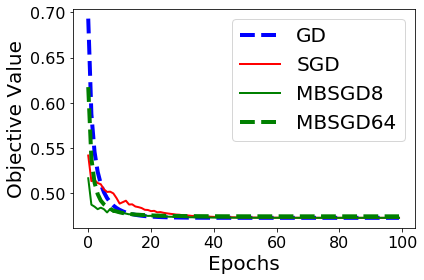

In [43]:
# plot the 4 curves:
fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))


line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-g', Linewidth = 2)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--g', Linewidth = 4)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_4_algorithms.pdf', format='pdf', dpi=1200)